reached_here
64
0
100
torch.Size([100, 100, 3])
1
100
torch.Size([100, 100, 3])
2
100
torch.Size([100, 100, 3])
3
100
torch.Size([100, 100, 3])
4
100
torch.Size([100, 100, 3])
5
100
torch.Size([100, 100, 3])
6
100
torch.Size([100, 100, 3])
7
100
torch.Size([100, 100, 3])
8
100
torch.Size([100, 100, 3])
9
100
torch.Size([100, 100, 3])
10
100
torch.Size([100, 100, 3])
11
100
torch.Size([100, 100, 3])
12
100
torch.Size([100, 100, 3])
13
100
torch.Size([100, 100, 3])
14
100
torch.Size([100, 100, 3])
15
100
torch.Size([100, 100, 3])
16
100
torch.Size([100, 100, 3])
17
100
torch.Size([100, 100, 3])
18
100
torch.Size([100, 100, 3])
19
100
torch.Size([100, 100, 3])
20
100
torch.Size([100, 100, 3])
21
100
torch.Size([100, 100, 3])
22
100
torch.Size([100, 100, 3])
23
100
torch.Size([100, 100, 3])
24
100
torch.Size([100, 100, 3])
25
100
torch.Size([100, 100, 3])
26
100
torch.Size([100, 100, 3])
27
100
torch.Size([100, 100, 3])
28
100
torch.Size([100, 100, 3])
29
100
torch.Size([100, 100, 3])
30
1

Moviepy - Done !
Moviepy - video ready NerF.mp4


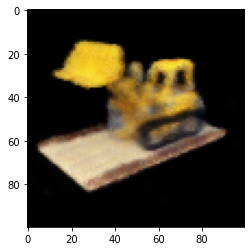

In [1]:
import os
import glob
import imageio
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import argparse
import json
import shutil
from moviepy.editor import ImageSequenceClip

def read_json(jsonPath):
	# open the json file
	with open(jsonPath, "r") as fp:
		# read the json data
		data = json.load(fp)
	
	# return the data
	return data

class tNerf(nn.Module):

    def __init__(self, filter_sz = 128, N_encode = 6):
        super(tNerf, self).__init__()

        self.layer1 = nn.Linear(3+3*2*N_encode, filter_sz)
        self.layer2 = nn.Linear(filter_sz, filter_sz)
        self.layer3 = nn.Linear(filter_sz, 4)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)

        return x


def get_image_c2w(jsonData, datasetPath):
	# define a list to store the image paths
	imagePaths = []
	
	# define a list to store the camera2world matrices
	c2ws = []
	# iterate over each frame of the data
	for frame in jsonData["frames"]:
		# grab the image file name
		imagePath = frame["file_path"]
		imagePath = imagePath.replace(".", datasetPath)
		imagePaths.append(f"{imagePath}.png")
		# grab the camera2world matrix
		c2ws.append(frame["transform_matrix"])
	
	# return the image file names and the camera2world matrices
	return imagePaths, c2ws
    
def read_images(imagePaths):
    images = []
    for i in range(len(imagePaths)):
        image = plt.imread(imagePaths[i])
        image.resize((100,100,3))
        # plt.imshow(image)
        # plt.show()
        images.append(image)
    images = np.array(images)
    images = torch.from_numpy(images)
    return images


def training(h, w, f, pose, near, far, Nc, batch_size, N_encode, model, device):
    
    ## getting query points of 100, 100, 32, 3
    ray_directions, ray_origins, depth_values, query_points = get_rays(h, w, f, pose, near, far, Nc, device)
    
    # flattening shape of 100, 100, 32 , 3 into 320000, 3
    flat_query_pts = query_points.reshape((-1,3))
      
    #positional encoding combining 320000, 3 into sin and cosine waves and collecting agian, resulting 320000, 39
    encoded_points = positional_encoding(flat_query_pts, N_encode)
    
    # taking in minibatches for the training into model
    batches = mini_batches(encoded_points, batch_size = batch_size)
    
    ## every batch is of 4096, 39
    predictions = []

    ## training in batch 
    for batch in batches:  
        predictions.append((model(batch)))
     
    ## output of the prediction and stacking them to make of original size and 320000, 4 : 4 is output size of model
    radiance_field_flat = torch.cat(predictions, dim=0)

    # creating a list of elements 100, 100, 32 , 4 , not required this line , just to reshape the above prediction tensor 
    # into 100, 100, 32, 4 from 320000, 4 by creating a dummy 
    unflat_shape = list(query_points.shape[:-1]) + [4]
    radiance_field = torch.reshape(radiance_field_flat, unflat_shape)
    
    ### columetric rendering 
    logits_rgb, _, D = render(radiance_field, ray_directions, depth_values)
    
    return logits_rgb, D

def get_rays(h, w, f, pose, near, far, Nc, device):

    #making meshgrid of x and y shape 
    x = torch.linspace(0, w-1, w)
    y = torch.linspace(0, h-1, h)
    xi, yi = torch.meshgrid(x, y, indexing='xy')
    xi = xi.to(device)
    yi = yi.to(device)
    
    # normalized coordinates
    norm_x = (xi - w * 0.5) / f
    norm_y = (yi - h * 0.5) / f

    #direction unit vectors matrix   USING colmap and considering z direction as -1 and combinign with x and y 
    directions = torch.stack([norm_x, - norm_y, -torch.ones_like(xi)], dim = -1)
    directions = directions[..., None,:]   # this extra dimesnion is to suffice 4D array , with 3 points at 100, 100, 32 points.
    

    #camera matrix : 3x3 matrix from the 4x4 projection matrix from the pose matrix 
    rotation = pose[:3, :3]
    translation = pose[:3, -1]

    # converting the ray directions into the camera direction
    camera_directions = directions * rotation
    
    # changing the dimesnions into 100, 100, 3 and normalizing 
    ray_directions = torch.sum(camera_directions, dim = -1)
    ray_directions = ray_directions/torch.linalg.norm(ray_directions, dim = -1, keepdims = True)
    ray_origins =  torch.broadcast_to(translation, ray_directions.shape)

    #get the sample points HERE near and far are define NC th number of instances 
    depth_val = torch.linspace(near, far, Nc) 
    
    # Adding the noise to the depth values 
    noise_shape = list(ray_origins.shape[:-1]) + [Nc]
    noise = torch.rand(size = noise_shape) * (far - near)/Nc
    
    ## here the noise size is 100, 100, 32 and the depth_cal size is 32 , creating depth points at 100, 100, 32 
    # by adding noise and from the start of the rays  
    depth_val = depth_val + noise
    depth_val = depth_val.to(device)
    
    ## creating the query points of 100, 100, 32, 4 in the direction of camera pose by muliplying with the ray directions.    
    query_points = ray_origins[..., None, :] + ray_directions[..., None, :] * depth_val[..., :, None]
    # print(query_points.shape)

    return ray_directions, ray_origins, depth_val, query_points


def TestOperation(images, poses, focal, height, width, lr, N_encode, epochs,\
                     near_threshold, far_threshold, batch_size, Nc, device, ModelPath, save_path):
    
    model = tNerf()
    CheckPoint = torch.load(ModelPath)
    model.load_state_dict(CheckPoint['model_state_dict'])
    model.to(torch.float64)
    model = model.to(device)
    count = 10041
    model.eval()
    print(len(images))
    Loss = []
    for i in range(len(images)):
        print(i)
        # img_idx = random.randint(0, images.shape[0]-1)
        # print(device)
        img = images[i].to(device)
        pose = poses[i].to(device)
        # print("in Test Operation")
        rgb_logit,D = training(height, width, focal, pose, near_threshold, far_threshold, Nc, batch_size, N_encode, model, device)
        
        print(len(rgb_logit))
        print(img.shape)
        loss = F.mse_loss(rgb_logit, img)
        # print("Loss", loss.item())
        Loss.append(loss)
        plt.imshow(rgb_logit.detach().cpu().numpy())
        # plt.show()
        plt.savefig(save_path + "/" + str(count) + ".png")
        count += 1
        # torch.cuda.empty_cache()
    print(sum(Loss)/len(Loss))
    
def positional_encoding(x, L):
    gamma = [x]
    for i in range(L):
        gamma.append(torch.sin((2.0**i) * x))
        gamma.append(torch.cos((2.0**i) * x))
    gamma = torch.cat(gamma, axis = -1)
    return gamma


def mini_batches(inputs, batch_size): 
    return [inputs[i:i + batch_size] for i in range(0, inputs.shape[0], batch_size)]

def render(radiance_field, ray_origins, depth_values):
    
    # radiance field is predictions of in RGB and Density 
    # ray origins are 100, 100, 3  with start points only
    # Depth values is ditance value sof rays at 100, 100, 32
    
    #volume density
    sigma_a = F.relu(radiance_field[...,3])    # output of this is 100, 100, 32      
    
    #color value at nth depth value
    rgb = torch.sigmoid(radiance_field[...,:3])      # output of tis 100, 100, 32, 3
    
    # applying the formuale for the volume rendering
    one_e_10 = torch.tensor([1e10], dtype = ray_origins.dtype, device = ray_origins.device)
    
    dists = torch.cat((depth_values[...,1:] - depth_values[...,:-1], one_e_10.expand(depth_values[...,:1].shape)), dim = -1)
    
    alpha = 1. - torch.exp(-sigma_a * dists) 
    
    weights = alpha * cumprod_exclusive(1. - alpha + 1e-10)     #transmittance
    
    # getting the rgb map
    rgb_map = (weights[..., None] * rgb).sum(dim = -2)          #resultant rgb color of n depth values
    
    # getting the depth map
    depth_map = (weights * depth_values).sum(dim = -1)
    
    # getting the accuracy map 
    acc_map = weights.sum(-1)
    
    return rgb_map, depth_map, acc_map

# To calculate the cumulative product used to calculate alpha
def cumprod_exclusive(tensor) :
    dim = -1
    cumprod = torch.cumprod(tensor, dim)
    cumprod = torch.roll(cumprod, 1, dim)
    cumprod[..., 0] = 1.

    return cumprod

def make_video(fps, path, video_file):
  print("Creating video {}, FPS={}".format(video_file, fps))
  clip = ImageSequenceClip(path, fps = fps)
  clip.write_videofile(video_file)
  shutil.rmtree(path)

def main():

    save_path = os.path.join("test_results")
    if os.path.exists(save_path):
        shutil.rmtree(save_path)
        os.mkdir(save_path)
    else:
        os.mkdir(save_path)
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    device = torch.device("cpu")
    jsonPath = "Data/transforms_test.json"
    datasetPath = "Data/test"
    data = read_json(jsonPath)
    imagePaths, poses = get_image_c2w(data, datasetPath)
    poses = np.array(poses)
    poses = torch.from_numpy(poses).to(device)
    images = read_images(imagePaths)
    images = images.to(device)
    ModelPath = "model3_lay.ckpt"
    Parser = argparse.ArgumentParser()
    Parser.add_argument('--CheckPointPath', default='../Checkpoints_dense/')
    Parser.add_argument('--NumEpochs', type=int, default=1000)
    Parser.add_argument('--Nc', type=int, default=64)
    Parser.add_argument('--MiniBatchSize', type=int, default=500, help='Size of the MiniBatch to use, Default:1')
    Parser.add_argument('--Nn', type=int, default=2)
    Parser.add_argument('--Nf',type=int, default=6)

#     Args = Parser.parse_args()
    Args, _ = Parser.parse_known_args()
    CheckPointPath = Args.CheckPointPath
    epochs = Args.NumEpochs
    Nc = Args.Nc
    batch_size = Args.MiniBatchSize
    near_threshold = Args.Nn
    far_threshold = Args.Nf
    focal = np.array([138.8889])
    focal = torch.from_numpy(focal).to(device)
    height, width = images.shape[1:3]
    # print(height,width)
    N_encode = 6
    lr = 5e-3
    print("reached_here")
    TestOperation(images[1:65], poses[1:65], focal, height, width, lr, N_encode, epochs,\
                     near_threshold, far_threshold, batch_size, Nc, device, ModelPath, save_path)

    video_file = 'NerF.mp4'
    make_video(5, save_path, video_file)

if __name__ == '__main__':
    main()
